### An Analysis of Crime Trends in Seattle (2008-2020)

In [1]:
#load libraries

library(RPostgreSQL)
library(DBI)
library(tidyverse)
library(plotly)
library(DT)
library(corrplot)

Warning message:
"package 'RPostgreSQL' was built under R version 3.6.3"
Loading required package: DBI

Warning message:
"package 'DBI' was built under R version 3.6.2"
Warning message:
"package 'tidyverse' was built under R version 3.6.3"
-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.3
v tibble  2.1.3     v dplyr   1.0.2
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0

Warning message:
"package 'ggplot2' was built under R version 3.6.3"
Warning message:
"package 'tibble' was built under R version 3.6.2"
Warning message:
"package 'tidyr' was built under R version 3.6.2"
Warning message:
"package 'readr' was built under R version 3.6.2"
Warning message:
"package 'purrr' was built under R version 3.6.2"
Warning message:
"package 'dplyr' was built under R version 3.6.3"
Warning message:
"package 'stringr' was built under R version 3.6.2"
Warning message:
"package 'forcats' was built under R versi

In [2]:
#set up connection to local database containing seattle tables
db <- 'postgres'
host_db <- 'LOCALHOST'
db_port <- '5432'
db_user <- 'postgres'
db_password <- '****'
con <- dbConnect(RPostgres::Postgres(),
                dbname=db,
                host=host_db,
                port=db_port,
                user=db_user,
                password=db_password)

In [3]:
#DATA DICTIONARY FOR SEATTLE CRIME DATASET IS FOUND HERE: 
#https://data.seattle.gov/api/views/tazs-3rd5/files/c1eb764d-95e4-4557-a60b-f0fda65d6d59?download=true&filename=SPD_DSG_OFFENSE_METADATA.pdf

In [74]:
#GET AN OVERVIEW OF THE DATASET
dbGetQuery(con, 'SELECT * FROM seattle_crime LIMIT 3')

Report Number,Offense ID,Offense Start DateTime,Offense End DateTime,Report DateTime,Group A B,Crime Against Category,Offense Parent Group,Offense,Offense Code,Precinct,Sector,Beat,MCPP,100 Block Address,Longitude,Latitude
<chr>,<dbl>,<dttm>,<dttm>,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
2020-064844,12630483385,2020-02-20 06:54:00,2020-02-20 09:04:00,2020-02-20 17:44:36,A,PROPERTY,BURGLARY/BREAKING&ENTERING,Burglary/Breaking & Entering,220,E,E,E3,CAPITOL HILL,15XX BLOCK OF BELMONT AVE,-122.3245,47.61466
2020-064865,12630481814,2020-02-20 16:40:00,2020-02-20 16:55:00,2020-02-20 17:37:27,A,PERSON,ASSAULT OFFENSES,Aggravated Assault,13A,E,E,E2,CAPITOL HILL,10XX BLOCK OF E PIKE ST,-122.3188,47.61409
2020-064793,12630473713,2020-02-20 15:15:00,NA,2020-02-20 17:30:10,A,PERSON,ASSAULT OFFENSES,Aggravated Assault,13A,N,U,U1,ROOSEVELT/RAVENNA,67XX BLOCK OF ROOSEVELT WAY NE,-122.3174,47.67765


In [4]:
#Check to see which datapoints provide the most information on times of crime
dbGetQuery(con, 'SELECT 
(SELECT COUNT(*) FROM seattle_crime) AS total_crimes, 
(SELECT COUNT(*) FROM seattle_crime WHERE "Offense Start DateTime" IS NULL) AS empty_start_times,
(SELECT COUNT(*) FROM seattle_crime WHERE "Offense End DateTime" IS NULL) AS empty_end_times, 
(SELECT COUNT(*) FROM seattle_crime WHERE "Report DateTime" IS NULL) AS empty_report_times')

total_crimes,empty_start_times,empty_end_times,empty_report_times
<int64>,<int64>,<int64>,<int64>
877926,648,408962,0


In [5]:
#look for errors and duplicated data
dbGetQuery(con, 'SELECT
    (SELECT COUNT("Report Number") FROM seattle_crime) as total_reports,
    (SELECT COUNT(DISTINCT "Report Number") FROM seattle_crime) as distinct_reports')

dbGetQuery(con, 'SELECT
    (SELECT COUNT("Offense ID") FROM seattle_crime) as total_offense_IDs,
    (SELECT COUNT(DISTINCT "Offense ID") FROM seattle_crime) as distinct_offense_IDs')

#The offense IDs are all unique and not duplicated. The total reports deviates from distinct reports 
#as some crimes are reported in the same report (per the data dictionary)

total_reports,distinct_reports
<int64>,<int64>
877926,818376


total_offense_ids,distinct_offense_ids
<int64>,<int64>
877926,877926


In [6]:
#CREATE VIEW TO INCLUDE ONLY THE YEARS WE WANT AND EXLUDE OUTLIER YEARS

dbSendQuery(con, 
'CREATE OR REPLACE VIEW sea_crime AS
SELECT "Report DateTime" AS report_datetime, 
"Crime Against Category" as crime_against,
"Offense Parent Group" AS offense_parent_group,
"Offense" as offense, "MCPP" AS mcpp
FROM seattle_crime WHERE DATE_PART($$year$$, "Report DateTime")
BETWEEN 2008 AND 2020')

<PqResult>
  SQL  CREATE OR REPLACE VIEW sea_crime AS
SELECT "Report DateTime" AS report_datetime, 
"Crime Against Category" as crime_against,
"Offense Parent Group" AS offense_parent_group,
"Offense" as offense, "MCPP" AS mcpp
FROM seattle_crime WHERE DATE_PART($$year$$, "Report DateTime")
BETWEEN 2008 AND 2020
  ROWS Fetched: 0 [complete]
       Changed: 0

In [8]:
#CONFIRM WE HAVE THE YEARS WE WANT
abs_crime_count <- dbGetQuery(con, "SELECT EXTRACT('year' FROM report_datetime) AS year, count(offense) 
FROM sea_crime GROUP BY year ORDER BY year DESC")

In [75]:
#plot time series of crime
fig <- plot_ly(abs_crime_count, x = ~year, y = ~count, type = 'scatter', mode = 'lines') %>%
layout(xaxis = list(title = 'Year'), yaxis=list(title = 'Crime Count'))

![g1](r-notebook/one.jpg)

In [76]:
#find most common offenses

offense_count <- dbGetQuery(con, 'SELECT offense, COUNT(OFFENSE), 
offense_parent_group FROM sea_crime_2020 
GROUP BY offense_parent_group, offense ORDER BY count desc LIMIT 10')

head(offense_count, n = 10)

fig <-plot_ly(offense_count, x=~offense, y=~count, type = 'bar') %>%
 layout(xaxis = list(title = 'Offense Type'), yaxis=list(title = 'Crime Count'))


,offense,count,offense_parent_group
,<chr>,<int64>,<chr>
1,Theft From Motor Vehicle,148243,LARCENY-THEFT
2,Burglary/Breaking & Entering,96367,BURGLARY/BREAKING&ENTERING
3,Destruction/Damage/Vandalism of Property,80305,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY
4,All Other Larceny,74020,LARCENY-THEFT
5,Simple Assault,68338,ASSAULT OFFENSES
6,Shoplifting,55053,LARCENY-THEFT
7,Motor Vehicle Theft,52493,MOTOR VEHICLE THEFT
8,Intimidation,28654,ASSAULT OFFENSES
9,Trespass of Real Property,27959,TRESPASS OF REAL PROPERTY


![g2](r-notebook/two.jpg)

In [12]:
#get the top crimes of each year and the percentage that those crimes make up for that given year

dbGetQuery(con, "with CTE AS(
select extract('year' FROM report_datetime) as year, offense, count(offense)
from sea_crime_2020 GROUP BY year, offense ORDER BY YEAR DESC, COUNT DESC),
cte2 as(
SELECT year, OFFENSE, COUNT, (count / sum(count) OVER (partition by year) * 100) as pct FROM cte group by year, offense, count ORDER BY YEAR DESC, COUNT DESC), cte3 as(
select year, offense, count, pct, rank() over (partition by year order by year desc, count desc) FROM cte2
ORDER BY year desc, count desc)
SELECT year, offense, count, ROUND(pct,2) FROM cte3 WHERE rank = 1")

year,offense,count,round
<dbl>,<chr>,<int64>,<dbl>
2020,Burglary/Breaking & Entering,10278,13.57
2019,Theft From Motor Vehicle,10748,15.20
2018,Theft From Motor Vehicle,11726,15.56
2017,Theft From Motor Vehicle,12528,17.13
2016,Theft From Motor Vehicle,13198,18.74
2015,Theft From Motor Vehicle,12675,18.66
2014,Theft From Motor Vehicle,13874,19.93
2013,Theft From Motor Vehicle,11721,18.42
2012,Theft From Motor Vehicle,9130,15.50


In [13]:
#find the neighborhood that ranks highest each year in crime, and what specific crime is reported most often

dbGetQuery(con, "
with cte as(
SELECT mcpp, EXTRACT('year' FROM report_datetime) as year, offense, count(offense) FROM sea_crime_2020 group by mcpp, year, offense ORDER BY YEAR DESC, COUNT DESC), cte2 as(
SELECT mcpp, year, offense, count, rank() over (partition by year ORDER BY year desc, count desc) FROM cte ORDER BY YEAR DESC, COUNT DESC)
 SELECT mcpp, YEAR, OFFENSE, COUNT FROM CTE2 where RANK = 1 GROUp BY year, mcpp, offense, count  order by year desc, mcpp")

#is the new number of burglaries and breaking and entering because of an increase in burglarly,
#or from a drop in shoplifting and thef from motor vehicle?

mcpp,year,offense,count
<chr>,<dbl>,<chr>,<int64>
QUEEN ANNE,2020,Burglary/Breaking & Entering,882
DOWNTOWN COMMERCIAL,2019,Shoplifting,955
DOWNTOWN COMMERCIAL,2018,Shoplifting,1258
DOWNTOWN COMMERCIAL,2017,Theft From Motor Vehicle,1327
DOWNTOWN COMMERCIAL,2016,Shoplifting,1166
DOWNTOWN COMMERCIAL,2015,Shoplifting,1160
DOWNTOWN COMMERCIAL,2014,Theft From Motor Vehicle,1254
DOWNTOWN COMMERCIAL,2013,Shoplifting,1118
DOWNTOWN COMMERCIAL,2012,Shoplifting,999


In [77]:
#Get B&E, shoplifting, and theft from MV data for last 4 years

bne <- dbGetQuery(con, "

SELECT DATE_PART('year', report_datetime) AS year, offense, count(offense)
FROM sea_crime_2020
WHERE offense IN ($$Burglary/Breaking & Entering$$, $$Shoplifting$$,
$$Theft From Motor Vehicle$$) AND DATE_PART('year', report_datetime) IN ('2020', '2019', '2018', '2017')
GROUP BY year, offense ORDER BY year desc

")
bne$year <- as.factor(bne$year)
fig <- plot_ly()
fig <- fig %>% add_trace(data = bne, x =~year, y=~count, color = ~offense, type = 'scatter', mode = 'lines') %>%
 layout(xaxis = list(title = 'Year'), yaxis=list(title = 'Crime Count'))


![g3](r-notebook/three.jpg)

In [15]:
#work with pivoting table to obtain times of day crimes are commited vs. month:

crime_times <- dbGetQuery(con, "

select * from crosstab(
$$select 
 date_part('hour', report_datetime)  as hour,

CASE

    WHEN cast(date_part('month', report_datetime) AS text) = '1' THEN 'Jan'
    WHEN cast(date_part('month', report_datetime) AS text) = '2' THEN 'Feb'
    WHEN cast(date_part('month', report_datetime) AS text) = '3' THEN 'Mar'
    WHEN cast(date_part('month', report_datetime) AS text) = '4' THEN 'Apr'
    WHEN cast(date_part('month', report_datetime) AS text) = '5' THEN 'May'
    WHEN cast(date_part('month', report_datetime) AS text) = '6' THEN 'June'
    WHEN cast(date_part('month', report_datetime) AS text) = '7' THEN 'July'
    WHEN cast(date_part('month', report_datetime) AS text) = '8' THEN 'Aug'
    WHEN cast(date_part('month', report_datetime) AS text) = '9' THEN 'Sep'
    WHEN cast(date_part('month', report_datetime) AS text) = '10' THEN 'Oct'
    WHEN cast(date_part('month', report_datetime) AS text) = '11' THEN 'Nov'
    WHEN cast(date_part('month', report_datetime) AS text) = '12' THEN 'Dec'

END AS month,

COUNT(offense) AS crimes

FROM sea_crime_2020 GROUP BY month, hour order by hour ASC$$)
    
AS crime_times(
hour float, Jan bigint, Feb bigint, Mar bigint, Apr bigint, may bigint, jun bigint, jul bigint, aug bigint,
sep bigint,
oct bigint, nov bigint, dec bigint)"
)


In [78]:
#do crimes occure more often in months typically regarded as warmer months?
crime_times_heat <- crime_times
hours <- c('12:00a', '1:00a','2:00a','3:00a','4:00a','5:00a','6:00a','7:00a','8:00a','9:00a','10:00a','11:00a',
          '12:00p','1:00p','2:00p','3:00p','4:00p','5:00p','6:00p','7:00p','8:00p','9:00p','10:00p', '11:00p')
rownames(crime_times_heat) <- hours
crime_times_heat <- crime_times_heat[,-1]
crime_times_heat <- sapply(crime_times_heat, as.integer)
head(crime_times_heat)
fig <- plot_ly(x = colnames(crime_times_heat), y = hours, z = crime_times_heat, type = "heatmap") %>%
 layout(xaxis = list(title = 'Month'), yaxis=list(title = 'Time of Day'))


jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
1938,2276,1978,1809,2011,2322,2179,1874,2225,1906,2009,2004
1814,2172,1848,1656,2053,2102,1932,1820,2020,1820,1988,1943
1528,1920,1723,1498,1723,1916,1757,1561,1705,1679,1766,1711
1000,1323,1144,999,1076,1281,1194,1092,1121,1135,1176,1128
911,1080,989,899,1033,1143,1051,926,1109,983,998,1006
792,1001,916,784,1006,1010,991,944,1006,903,970,983


![g4](r-notebook/four.jpg)

In [17]:
#break down crime counts into violent and nonviolent
crime_types <- dbGetQuery(con ,"
with cte AS( -- year, offense, count
SELECT EXTRACT('year' FROM report_datetime)as year, 
sum(count(offense)) OVER (partition by EXTRACT('year' FROM report_datetime) order by EXTRACT('year' FROM report_datetime) desc) AS tot_crimes,
CASE
WHEN offense_parent_group = 'ASSAULT OFFENSES' AND crime_against = 'PERSON' THEN 'VIOLENT'
WHEN offense_parent_group = 'KIDNAPPING/ABDUCTION' AND crime_against = 'PERSON'  THEN 'VIOLENT'
WHEN offense_parent_group = 'ROBBERY' AND crime_against = 'PERSON'  THEN 'VIOLENT'
WHEN offense_parent_group = 'HOMICIDE' AND crime_against = 'PERSON'  THEN 'VIOLENT'
WHEN offense_parent_group = 'SEX OFFENSES' AND crime_against = 'PERSON' THEN 'VIOLENT'
ELSE 'NON-VIOLENT'
END crime_grade,
count(offense) as crime_count FROM sea_crime_2020 
GROUP BY year, crime_grade
)
SELECT year, crime_grade, crime_count, round(crime_count / tot_crimes,2) as pct FROM cte ORDER BY YEAR DESC, PCT desc")

head(crime_types)

,year,crime_grade,crime_count,pct
,<dbl>,<chr>,<int64>,<dbl>
1,2020,NON-VIOLENT,64792,0.86
2,2020,VIOLENT,10948,0.14
3,2019,NON-VIOLENT,58692,0.83
4,2019,VIOLENT,12008,0.17
5,2018,NON-VIOLENT,63349,0.84
6,2018,VIOLENT,12013,0.16


In [79]:
#visualize ratio of violent vs. nonviolent crimes over the time series

fig <- plot_ly() %>%
    add_trace(data = crime_types, x=~year, y =~pct, color =~crime_grade, type = 'bar') %>%
layout(barmode = 'stack')  %>% layout(xaxis = list(title = 'Year'), yaxis=list(title = 'Percent of Total Crime'))


![g5](r-notebook/five.jpg)

In [19]:
sea_murder <- dbGetQuery(con, 
                         
"with cte AS(
    SELECT
        EXTRACT('YEAR' FROM report_datetime) AS year,
        ROUND(AVG(CASE WHEN offense ILIKE '%murder%' THEN 1 ELSE 0 END) * 100, 2) AS pct_murders_of_all_crime
        FROM sea_crime SEA_CRIME GROUP BY year ORDER BY year DESC),
cte2 AS
        (select count(offense), EXTRACT('year' from report_datetime) AS year 
        FROM sea_Crime 
        WHERE offense ILIKE '%murder%' 
        GROUP BY year 
        ORDER BY year DESC),
cte3 AS
        (SELECT cte.year, cte.pct_murders_of_all_crime, cte2.count FROM
        cte NATURAL JOIN cte2),
cte4 AS
        (SELECT year, pct_murders_of_all_crime, (COUNT * 1.0) as murder_count, population 
        FROM cte3 
        NATURAL JOIN seattle_pop 
        ORDER BY year DESC), 
cte5 AS
        (SELECT *,
        ROUND(CAST(murder_count / (CAST(population as numeric)/ 100000.0) AS numeric),2) AS per_100k FROM cte4)

    SELECT *,
    round(CAST(population - LEAD(population,1) OVER () AS numeric) / LEAD(population) OVER () * 100,2) AS PCT_POP_CHANGE,
    ROUND(CAST(per_100k - LEAD(per_100k,1) OVER () AS numeric) / LEAD(per_100k) OVER () * 100,2) AS PCT_per_100k_CHANGE,
    ROUND(CAST(murder_count - LEAD(murder_count,1) OVER () AS numeric) / LEAD(murder_count) OVER () * 100,2) AS PCT_murder_count_change
    FROM cte5;")

head(sea_murder)


,year,pct_murders_of_all_crime,murder_count,population,per_100k,pct_pop_change,pct_per_100k_change,pct_murder_count_change
,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,2020,0.06,47,767312,6.13,1.81,64.78,67.86
2,2019,0.04,28,753675,3.72,1.17,-13.49,-12.50
3,2018,0.04,32,744955,4.30,2.79,15.28,18.52
4,2017,0.04,27,724745,3.73,2.90,38.15,42.11
5,2016,0.03,19,704352,2.70,2.91,-31.47,-29.63
6,2015,0.04,27,684451,3.94,2.41,14.53,17.39


In [80]:
fig <- plot_ly()

fig <- fig %>% add_trace(data = sea_murder, x=~year, y=~pct_per_100k_change, name = 'Percent per 100k Change', type='scatter', mode = 'lines', yaxis="y2")
fig <- fig %>% add_trace(data = sea_murder, x=~year, y=~pct_pop_change, name = 'Percent Population Change', type = 'scatter', 
                         mode = 'lines')

fig <- fig %>% layout(yaxis2 = list(
  overlaying = "y",
  side = "right",
  title = "Percent Population Change"),
                      yaxis = list(title = "Percent per 100k change"), xaxis = list(title = 'Year'))

![g6](r-notebook/six.jpg)

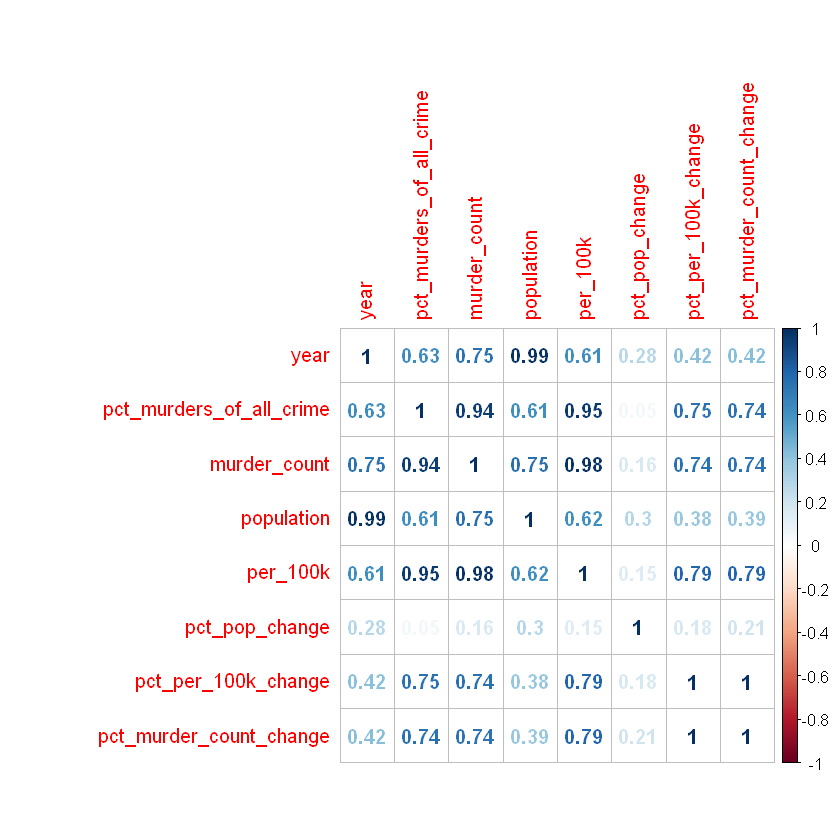

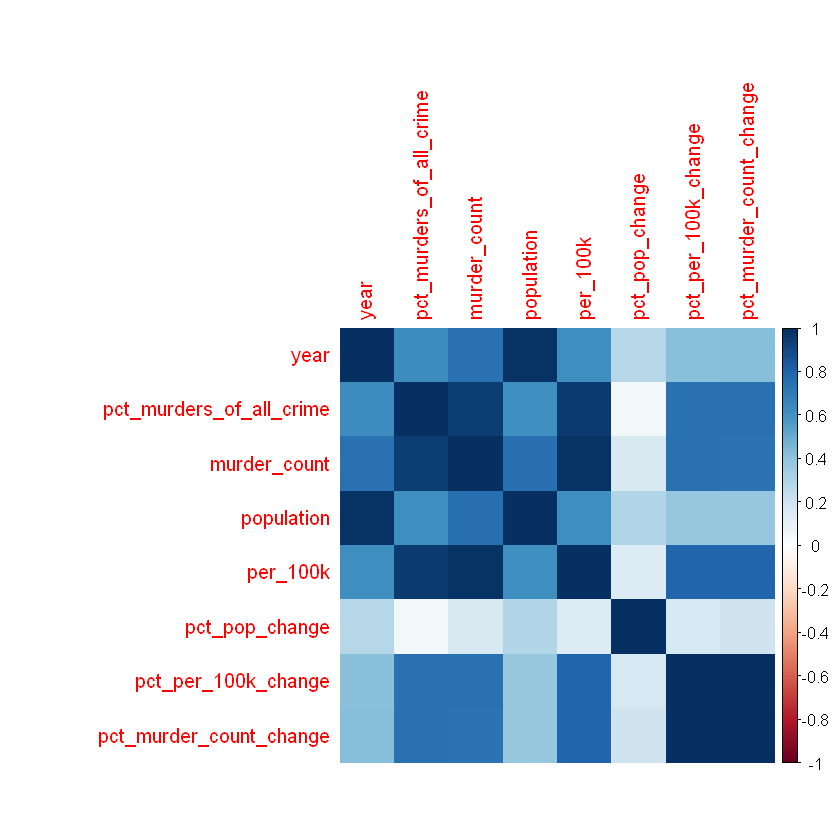

In [20]:
#visualize correlatrion matrix to see if any correlation is observed between the metrics, 
#particularly for population and change in crime

corrplot(cor(sea_murder, use ="complete.obs"), method = "number")
corrplot(cor(sea_murder, use ="complete.obs"), method = "color")

In [56]:
#at what time do most violent crimes occur? 

violent_times <- dbGetQuery(con, "
SELECT offense, count(offense), DATE_PART('hour', report_datetime) as time
FROM sea_crime_2020 WHERE DATE_PART('year', report_datetime) IN ('2020',
'2019', '2018')
AND offense_parent_group IN 
('ASSAULT OFFENSES', 'KIDNAPPING/ABDUCTION', 'ROBBERY', 'HOMICIDE', 'SEX OFFENSES')
group by offense, time

")

violent_times <- violent_times %>% 
    mutate(real_time = case_when(
        
        time == 1 ~ '1:00a',
        time == 2 ~ '2:00a',
        time == 3 ~ '3:00a',
        time == 4 ~ '4:00a',
        time == 5 ~ '5:00a',
        time == 6 ~ '6:00a',
        time == 7 ~ '7:00a',
        time == 8 ~ '8:00a',
        time == 9 ~ '9:00a',
        time == 10 ~ '10:00a',
        time == 11 ~ '11:00a',
        time == 12 ~ '12:00p',
        time == 13 ~ '1:00p',
        time == 14 ~ '2:00p',
        time == 15 ~ '3:00p',
        time == 16 ~ '4:00p',
        time == 17 ~ '5:00p',
        time == 18 ~ '6:00p',
        time == 19 ~ '7:00p',
        time == 20 ~ '8:00p',
        time == 21 ~ '9:00p',
        time == 22 ~ '10:00p',
        time == 23 ~ '11:00p',
        time == 0 ~ '12:00a'

    )
)

Time  = factor(violent_times$real_time, levels=c('12:00a', '1:00a','2:00a','3:00a','4:00a','5:00a','6:00a','7:00a',
                                                    '8:00a','9:00a','10:00a','11:00a',
          '12:00p','1:00p','2:00p','3:00p','4:00p','5:00p','6:00p','7:00p','8:00p','9:00p','10:00p', '11:00p'))
    
fig <- plot_ly(data = violent_times, z =~count, x=~offense, y=~Time, type='heatmap')  %>%
layout(xaxis = list(title = 'Offense'), yaxis=list(title = 'Time of Day'))
#graph most common times specific crimes are occuring in the day

In [23]:
#In what neighborhoods do most violent crimes occur? 


violent_2020 <- dbSendQuery(con, "CREATE OR REPLACE VIEW VIOLENT AS (
with cte AS( -- year, offense, count
SELECT EXTRACT('year' FROM report_datetime)as year, mcpp, sum(count(offense)) OVER (partition by EXTRACT('year' FROM report_datetime)
              order by EXTRACT('year' FROM report_datetime) desc) AS tot_crimes,
CASE
WHEN offense_parent_group = 'ASSAULT OFFENSES' AND crime_against = 'PERSON' THEN 'VIOLENT'
WHEN offense_parent_group = 'KIDNAPPING/ABDUCTION' AND crime_against = 'PERSON'  THEN 'VIOLENT'
WHEN offense_parent_group = 'ROBBERY' AND crime_against = 'PERSON' THEN 'VIOLENT'
WHEN offense_parent_group = 'HOMICIDE' AND crime_against = 'PERSON'  THEN 'VIOLENT'
WHEN offense_parent_group = 'SEX OFFENSES' AND crime_against = 'PERSON' THEN 'VIOLENT'
ELSE 'NON-VIOLENT'
END crime_grade,

count(offense) as crime_count FROM sea_crime_2020 WHERE DATE_PART('year', report_datetime) = '2020'
GROUP BY year, mcpp, crime_grade
), CTE2 as(
SELECT year, mcpp, crime_grade, crime_count, ROUND(100 * round(crime_count / tot_crimes,4),2) as pct, rank() OVER (partition by YEAR ORDER BY round(crime_count / tot_crimes,4) desc)
FROM cte
WHERE crime_Grade = 'VIOLENT'
ORDER BY YEAR DESC, crime_count desc)

select YEAR, mcpp, crime_grade, crime_count, pct from cte2)")


![g7](r-notebook/seven.jpg)

In [25]:
#gives the top violent crime neighborhoods in 2020, and their
#count as a percent of all overall crime. (including nonviolent)

top_10_violent_2020 <- dbGetQuery(con, "select * from violent LIMIT 10") 
top_10_violent_2020

year,mcpp,crime_grade,crime_count,pct
<dbl>,<chr>,<chr>,<int64>,<dbl>
2020,DOWNTOWN COMMERCIAL,VIOLENT,899,1.19
2020,CAPITOL HILL,VIOLENT,849,1.12
2020,SLU/CASCADE,VIOLENT,608,0.80
2020,FIRST HILL,VIOLENT,537,0.71
2020,NORTHGATE,VIOLENT,485,0.64
2020,UNIVERSITY,VIOLENT,457,0.60
2020,QUEEN ANNE,VIOLENT,436,0.58
2020,BELLTOWN,VIOLENT,397,0.52
2020,CHINATOWN/INTERNATIONAL DISTRICT,VIOLENT,346,0.46


In [82]:
#graph top 10 most violent neighborhoods in Seattle
fig <- plot_ly(data = top_10_violent_2020, x=~mcpp, y =~crime_count, type = 'bar') %>%  layout(xaxis = list(title = 'Neighborhood'), yaxis=list(title = 'Crime Count'))


![g8](r-notebook/eight.jpg)

In [48]:
violent_all <- dbGetQuery(con, "
with cte AS( -- year, offense, count
SELECT EXTRACT('year' FROM report_datetime)as year, mcpp, sum(count(offense)) OVER (partition by EXTRACT('year' FROM report_datetime)
              order by EXTRACT('year' FROM report_datetime) desc) AS tot_crimes,
CASE
WHEN offense_parent_group = 'ASSAULT OFFENSES' AND crime_against = 'PERSON' THEN 'VIOLENT'
WHEN offense_parent_group = 'KIDNAPPING/ABDUCTION' AND crime_against = 'PERSON'  THEN 'VIOLENT'
WHEN offense_parent_group = 'ROBBERY' AND crime_against = 'PERSON' THEN 'VIOLENT'
WHEN offense_parent_group = 'HOMICIDE' AND crime_against = 'PERSON'  THEN 'VIOLENT'
WHEN offense_parent_group = 'SEX OFFENSES' AND crime_against = 'PERSON' THEN 'VIOLENT'
ELSE 'NON-VIOLENT'
END crime_grade,

count(offense) as crime_count FROM sea_crime_2020 
GROUP BY year, mcpp, crime_grade
), CTE2 as(
SELECT year, mcpp, crime_grade, crime_count, ROUND(100 * round(crime_count / tot_crimes,4),2) as pct, rank() OVER (partition by YEAR ORDER BY round(crime_count / tot_crimes,4) desc)
FROM cte
WHERE crime_Grade = 'VIOLENT'
ORDER BY YEAR DESC, crime_count desc)

select YEAR, mcpp, crime_grade, crime_count, pct from cte2")

In [83]:
#graph change in violent crimes by neighborhood over 2008-2020

fig <- plot_ly(data=violent_all, x=~factor(year), y=~mcpp, z=~crime_count, type= 'heatmap', height = "800") %>%
    layout(xaxis = list(title = 'Year'), yaxis=list(title = 'Neighborhood'))


![g9](r-notebook/nine.jpg)